In [ ]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk,plot_residual
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('highest')
device = torch.device("cuda") if torch.cuda.is_available() else "mps"
print(device)

In [10]:
! export WORKON_HOME=/global/homes/l/lindajin/virtualenvs
! module load python
! source virtualenvwrapper.sh
! workon env1

/bin/bash: workon: command not found


In [8]:
! workon env1
! which python

/bin/bash: workon: command not found
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/bin/python


In [2]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4


[rank: 0] Seed set to 7


In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # the first convolutional layer, followed by batch normalization,
        # and then the ReLU activation function
        #input (12, 1, 256, 256) --> (12, 64, 256, 256)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # second convolutional layer has a similar sequence
        # (12, 64, 256, 256) --> (12, 128, 128, 128)
        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # (12, 128, 128, 128) --> (12, 64, 256, 256)
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # (12, 64, 256, 256) --> (12, 1, 256, 256)
        self.output_layer = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1) 


    # this is the forward pass!
    def forward(self, x):
        out = self.conv1(x)
        out = self.downsample(out)
        out = self.upsample(out)
        out = self.output_layer(out, output_size=x.size())
        return out

In [4]:
sys.path.append('/pscratch/sd/l/lindajin/Pytorch-UNet/unet')
from unet_model import UNet
class BasicCNN(LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 3.0e-4,
        weight_decay: float = 1.0e-5,
        n_sampling_steps: int = 250,
        draw_figure=None,
        plot_residual=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.plot_residual=plot_residual
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, x) -> Tensor:
        return self.model(x)

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map, true_map = batch
        mtot_pred = self(cdm_map)
        loss = l1_loss(mtot_pred, true_map)
        loss = loss.float()
        
        return loss

    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        return self.evaluate(batch, "train")


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning)
            loss = l1_loss(x, sample)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset, stage='val')
            self.log_dict({'val_loss': loss}, on_epoch=True)
            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning)
            loss = mse_loss(x, sample)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset)
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer,
            T_0=10,

        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [5]:
import importlib
sys.path.append(os.path.expanduser("~"))
import utils  # Import the module you want to reload
import camel_dataloader


# Make changes to 'my_module.py'

importlib.reload(utils) 
importlib.reload(camel_dataloader) 
from utils import draw_figure,compute_pk,plot_residual
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D

cuda
1


In [5]:
cnn = BasicCNN(
        model = UNet(1,1,use_fourier_features=False),#SimpleNet() #ResnetGenerator(1,1) #SimpleNet()
        dataset=dataset,
        learning_rate=learning_rate,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        plot_residual=plot_residual
    )
    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_loss",
         save_top_k=1, # save only the best ckpt
        mode="min",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, #6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="baryonize_DM",
            experiment_name='Unet_TF_L1_high_pass',
            #'Unet_TF_fft' too slow
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=10, #1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint],
    )

/global/homes/l/lindajin/.conda/envs/env1/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
CometLogger will be initialized in online mode


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## CNN + TF: m_cdm -> m_tot-m_cdm_tf (3D->2D: 25 thickness)

In [6]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size,
    ) 

In [8]:
print(np.shape(dm_TF.train_data), len(dm_TF.valid_data),len(dm_TF.test_data))
one_batch = next(iter(dm_TF.test_dataloader()))
print(np.shape(one_batch))

(2400, 2, 1, 256, 256) 420 180
(2, 50, 1, 256, 256)


In [ ]:
print(torch.is_floating_point(one_batch[0]), one_batch[0].dtype, one_batch[1].dtype, UNet(1,1)(one_batch[0]).dtype, cnn(one_batch[0]).shape)
for param in cnn.parameters():
    if param.dtype != torch.float32:
        print(f'wrong dtype{param.data.dtype}')

In [ ]:
trainer.fit(model=cnn, datamodule=dm_TF) 

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/4f4d2f13edc540039c188a45e36a0ec3


Detected KeyboardInterrupt, attempting graceful shutdown ...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ------------------------

In [13]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/7de78940c94547ad878fde7565871c98/checkpoints/latest-epoch=9-step=2000.ckpt


You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/3f0389e6f5234a5c9ee520eb811453d8

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/7de78940c94547ad878fde7565871c98/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model

Testing: |          | 0/? [00:00<?, ?it/s]

cuda:0


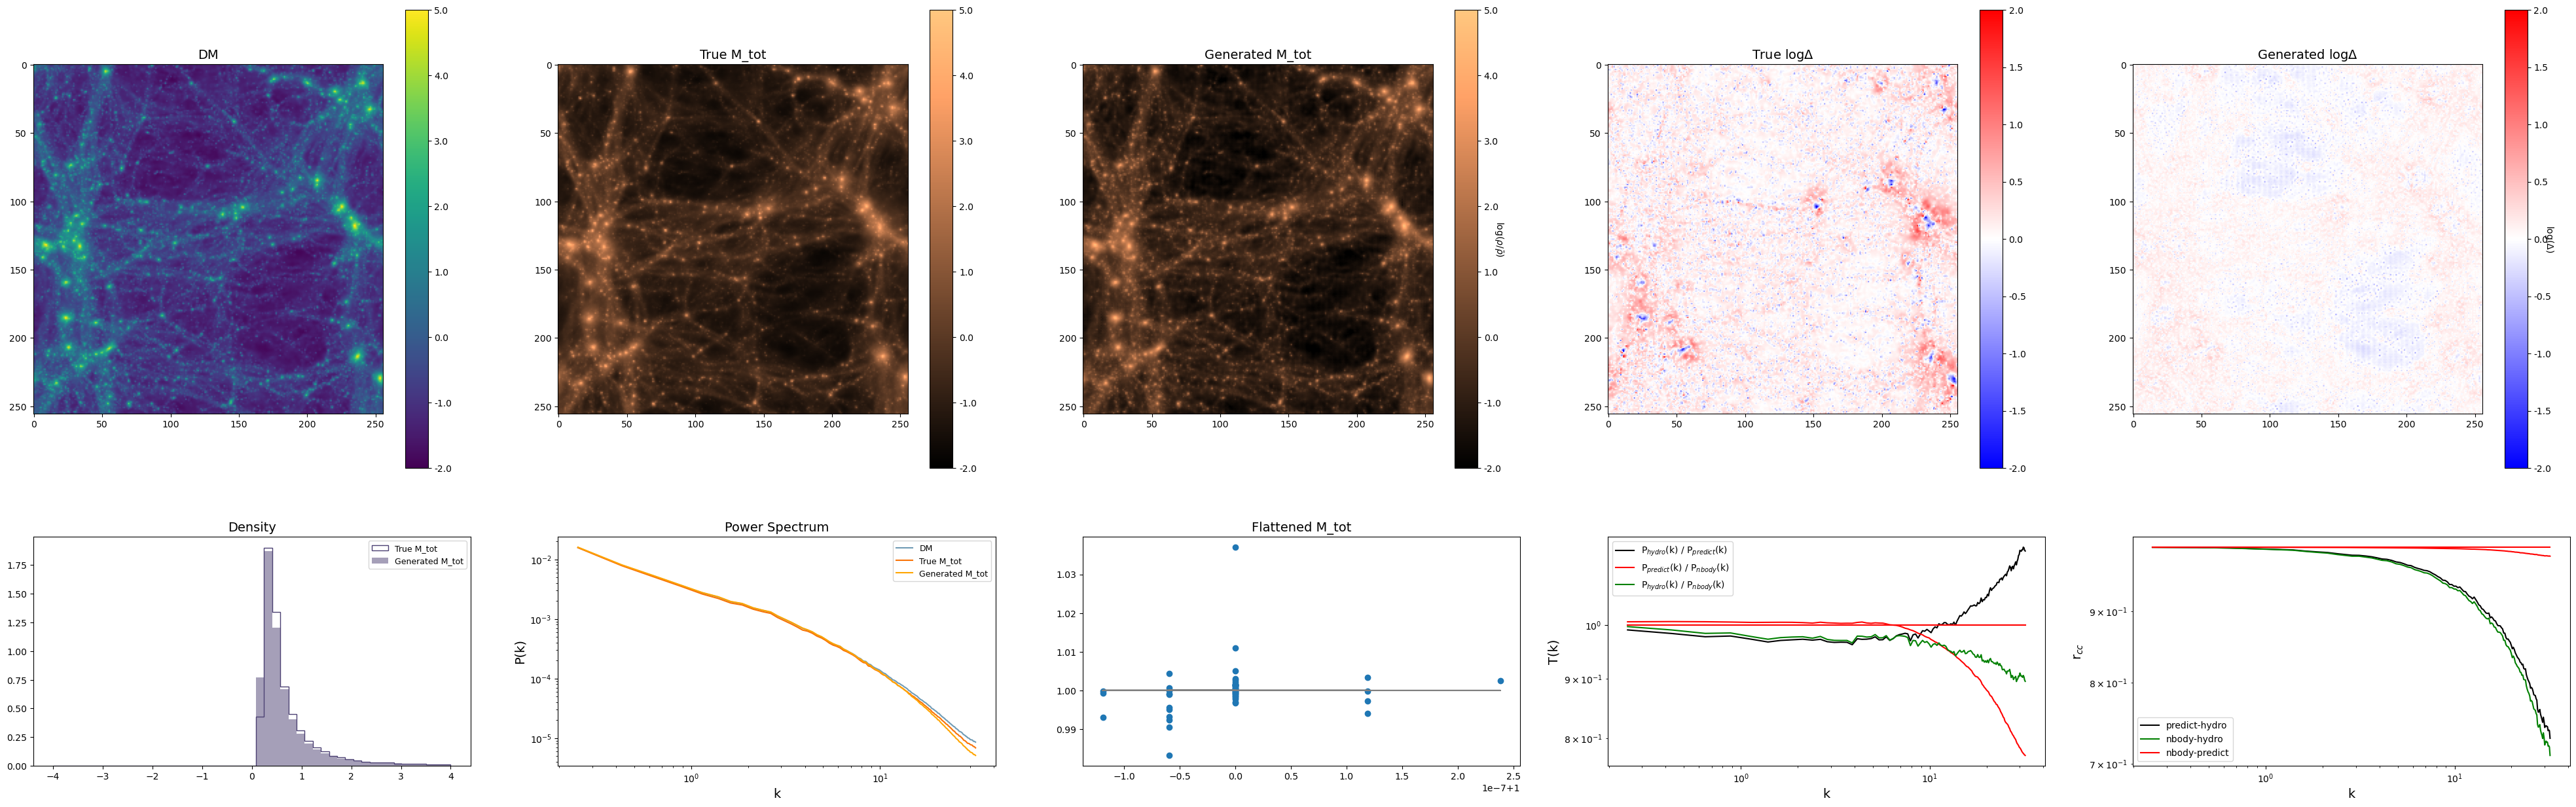

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.7049956321716309     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_padding_circular
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/3f0389e6f5234a5c9ee520eb811453d8
COMET INFO:   Metrics:
COMET INFO:     test_loss : 1.7049956321716309
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_padding_circular
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     n_sampling_steps : 250
COMET INFO:     weight_decay     : 1e-05
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO

In [7]:
path = '/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/7de78940c94547ad878fde7565871c98/checkpoints/latest-epoch=9-step=2000.ckpt'
test_loss = trainer.test(model=cnn.to(device), datamodule=dm_TF,  ckpt_path = path)

In [16]:
trainer.validate(model=cnn, datamodule=dm_TF, ckpt_path = path)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7de78940c94547ad878fde7565871c98

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/7de78940c94547ad878fde7565871c98/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/7de78940c94547ad878fde7565871c98/checkpoints/latest-epoch=9-step=2000.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.0552995204925537     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_padding_circular
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7de78940c94547ad878fde7565871c98
COMET INFO:   Metrics:
COMET INFO:     val_loss : 1.0552995204925537
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_padding_circular
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     n_sampling_steps : 250
COMET INFO:     weight_decay     : 1e-05
COMET INFO:   Uploads:
COMET INFO:     figures     : 1
COMET INFO:     mode

[{'val_loss': 1.0552995204925537}]

In [46]:
trainer.logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/f82bd19f11ba472c827e20906e0f0fd5

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/f82bd19f11ba472c827e20906e0f0fd5
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF
COMET INFO: 
COM

## Original CNN: m_cdm -> m_tot-m_cdm (CMD 2D: 5 thickness)

In [14]:
dm = get_astro_data(
        dataset,
        num_workers=num_workers,
        # resize=cropsize,
        batch_size=batch_size,
    )

In [15]:
print(np.shape(dm.train_data), len(dm.valid_data),len(dm.test_data))
one_batch = next(iter(dm.test_dataloader()))
print(np.shape(one_batch),one_batch[0].dtype)

(12000, 2, 1, 256, 256) 3000 525
(2, 50, 1, 256, 256) torch.float32


In [24]:
#trainer.fit(model=cnn, datamodule=dm)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7324872b734c47469bd8054d8263538d

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 31.0 M | train
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)
95        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

cuda:0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 0, global step 1000: 'val_loss' reached 0.18386 (best 0.18386), saving model to '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/best_model-epoch=0-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 1, global step 2000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 2, global step 3000: 'val_loss' reached 0.17999 (best 0.17999), saving model to '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/best_model-epoch=2-step=3000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 3, global step 4000: 'val_loss' reached 0.16851 (best 0.16851), saving model to '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/best_model-epoch=3-step=4000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 4, global step 5000: 'val_loss' reached 0.15215 (best 0.15215), saving model to '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/best_model-epoch=4-step=5000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 5, global step 6000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 6, global step 7000: 'val_loss' reached 0.14460 (best 0.14460), saving model to '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/best_model-epoch=6-step=7000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 7, global step 8000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 8, global step 9000: 'val_loss' reached 0.14400 (best 0.14400), saving model to '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/best_model-epoch=8-step=9000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 9, global step 10000: 'val_loss' reached 0.12026 (best 0.12026), saving model to '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/best_model-epoch=9-step=10000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Pytorch_unet
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7324872b734c47469bd8054d8263538d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr-AdamW [10] : (2.4471741852423235e-05, 0.001)
COMET INFO:     val_loss [10] : (0.12026014178991318, 0.21123915910720825)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-ligh

In [27]:
path = trainer.checkpoint_callback.best_model_path 
print(path)
path = '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt'

/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7324872b734c47469bd8054d8263538d

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

cuda:0


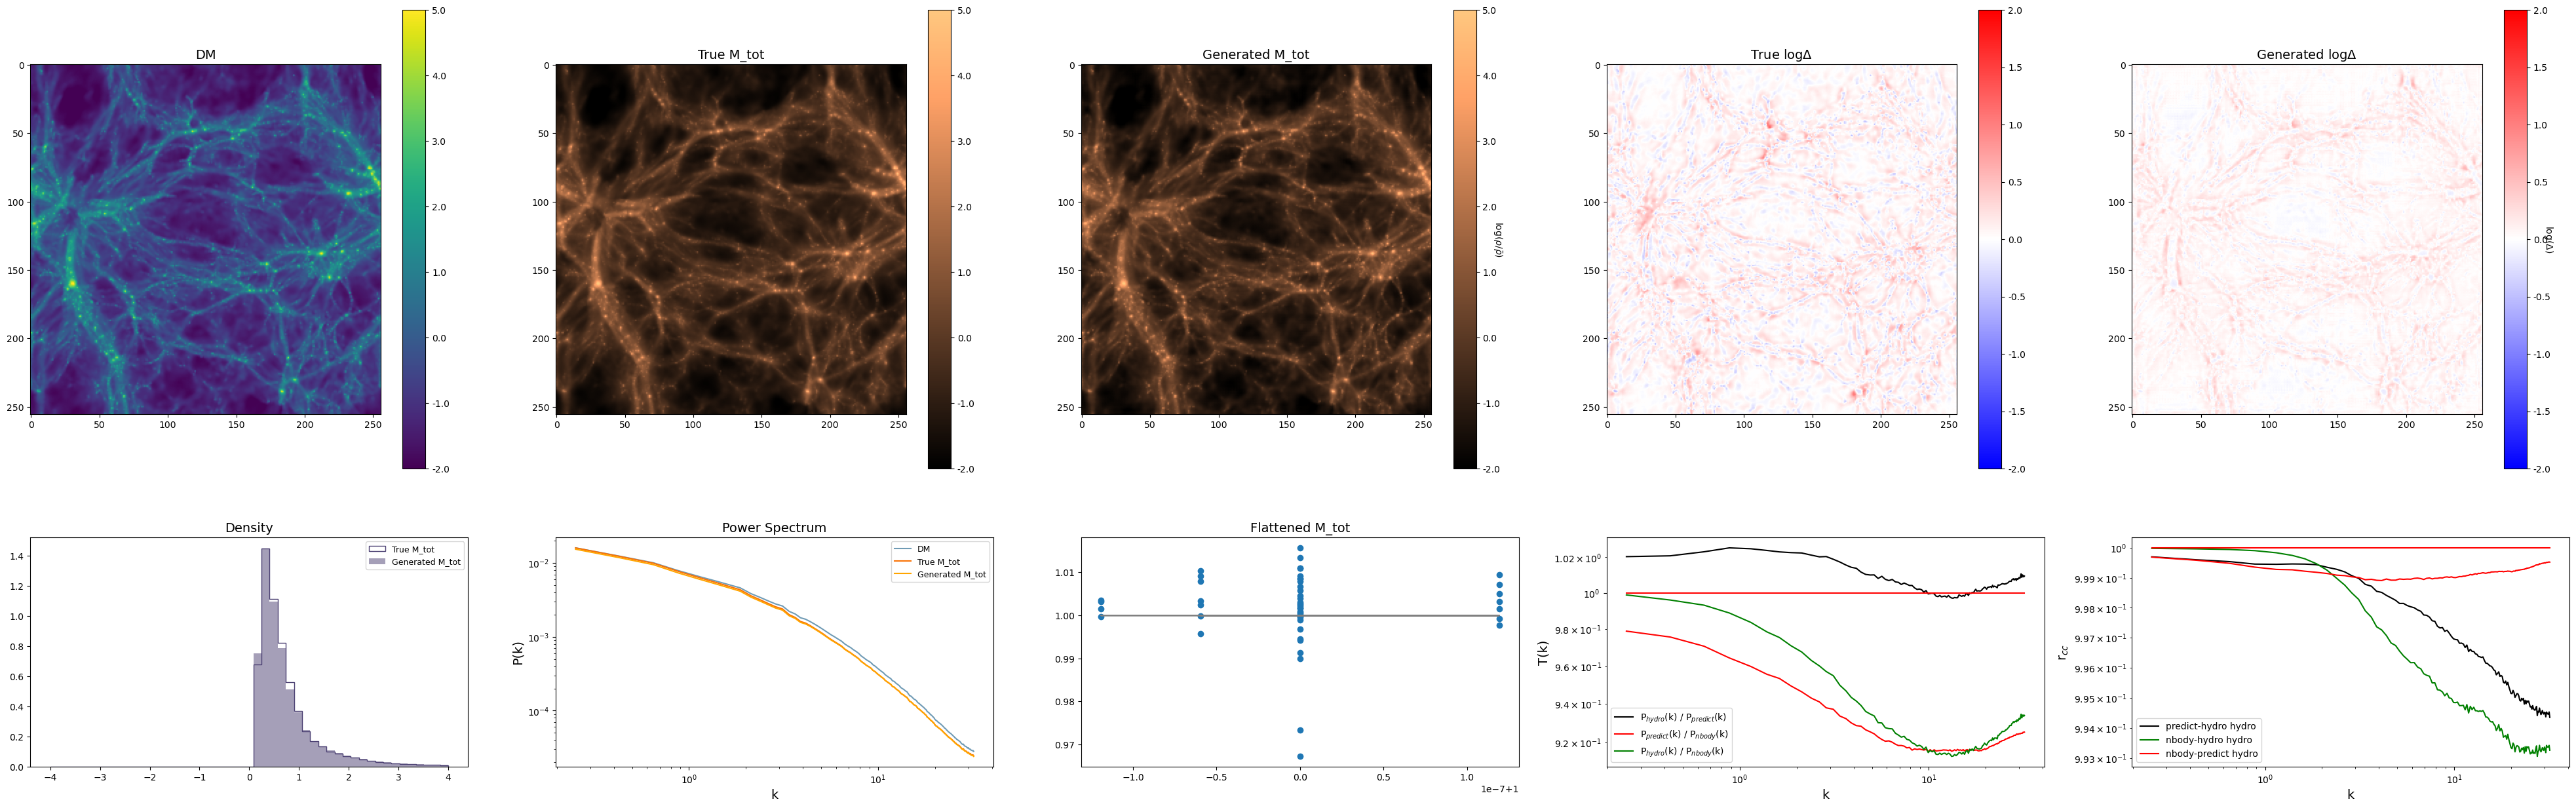

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.18836350739002228    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Pytorch_unet
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7324872b734c47469bd8054d8263538d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_loss [2] : (0.18836350739002228, 0.18836352229118347)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Pytorch_unet
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     n_sampling_steps : 250
COMET INFO:     weight_decay     : 1e-05
COMET INFO:   Uploads:
COMET INFO:     figures     

In [28]:
device = torch.device("cuda:2")
test_loss = trainer.test(model=cnn.to(device), datamodule=dm,  ckpt_path = path)

In [29]:
trainer.validate(model=cnn, datamodule=dm, ckpt_path = path)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7324872b734c47469bd8054d8263538d

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     0.13773113489151      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Pytorch_unet
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7324872b734c47469bd8054d8263538d
COMET INFO:   Metrics:
COMET INFO:     val_loss : 0.13773113489151
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Pytorch_unet
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     n_sampling_steps : 250
COMET INFO:     weight_decay     : 1e-05
COMET INFO:   Uploads:
COMET INFO:     figures     : 1
COMET INFO:     model graph : 1
COMET INFO: 
C

[{'val_loss': 0.13773113489151}]

In [ ]:
trainer.logger.experiment.end()

In [ ]:
ckpt= '/global/homes/l/lindajin/baryonification_cnn/baryonize_DM/eaca96d55bbd4a30ae7f56eaab6e55d8/checkpoints/latest-epoch=9-step=10000.ckpt'
state_dict=torch.load(ckpt)["state_dict"]
cnn.load_state_dict(state_dict)
cnn.eval()

'''
plot on IllustrisTNG data
'''
conditioning, x =  next(iter(dm.test_dataloader()))   #ValueError: too many values to unpack (expected 2)
with torch.no_grad():
    sample = cnn(conditioning)
fig = draw_figure(x,sample,conditioning,'Astrid')
fig.savefig(f'baryonize_DM/eaca96d55bbd4a30ae7f56eaab6e55d8/test_IllustrisTNG_1P.png')
plt.show()